In [1]:
import glob
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import matplotlib.style as ms
ms.use("seaborn-muted")
%matplotlib inline

import IPython.display

import librosa
import librosa.display

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
import pickle


In [2]:
def load_files(filepaths):
    raw_sounds = []
    for filepath in filepaths:
        X,sr = librosa.load(filepath)
        raw_sounds.append(X)
    return raw_sounds


def plot_waves(sound_names,raw_sounds):
    i = 1
    fig = plt.figure(figsize=(25,60), dpi = 900)
    for n,f in zip(sound_names,raw_sounds):
        print(n,f)
        plt.subplot(10,1,i)
        librosa.display.waveplot(np.array(f),sr=22050)
        plt.title(n.title())
        i += 1
    plt.suptitle("Figure 1: Waveplot",x=0.5, y=0.915,fontsize=18)
    plt.show()

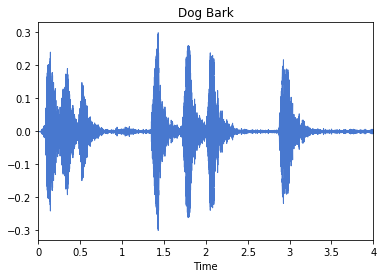

In [3]:
sound_file_paths = ["Sound-Data/fold1/15564-2-0-0.wav", "Sound-Data/fold1/21684-9-0-5.wav"]

sound_names = ["children playing", "street music"]

raw_sounds = load_files(sound_file_paths)

# plot_waves(sound_names,raw_sounds)



# X, sr = librosa.load("Sound-Data/fold1/7383-3-0-0.wav")
# librosa.display.waveplot(np.array(X), sr=22050)
# plt.title("dog bark".title())
# plt.show()



In [4]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

def parse_audio_files(parent_dir,sub_dirs,file_ext="*.wav"):
    features, labels = np.empty((0,193)), np.empty(0)
    for label, sub_dir in enumerate(sub_dirs):
        print(label, sub_dir)
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            try:
                mfccs, chroma, mel, contrast,tonnetz = extract_feature(fn)
            except Exception as e:
                print("Error encountered while parsing file: ", fn)
                continue
            ext_features = np.hstack([mfccs,chroma,mel,contrast,tonnetz])
            features = np.vstack([features,ext_features])
            
            labels = np.append(labels, fn.split('\\')[2].split('-')[1])
    return np.array(features), np.array(labels, dtype = np.int)

def one_hot_encode(labels):
    print(labels)
    n_labels = len(labels)
    print(n_labels)
    n_unique_labels = len(np.unique(labels))
    print(n_unique_labels)
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels),labels] = 1
    return one_hot_encode

In [18]:
print("Starting Audio parsing")
parent_dir = 'Sound-Data'
dirs = ["fold1","fold2", "fold3"]
# dirs = ["fold4"]
features, labels = parse_audio_files(parent_dir, dirs)

print("Done parsing audio")

Starting Audio parsing
0 fold1
1 fold2
2 fold3
Done parsing audio


In [19]:
f = open('features.pckl', 'wb')
pickle.dump(features,f)
f.close()
fl = open('labels.pckl', 'wb')
pickle.dump(labels,fl)
fl.close()

In [20]:
f = open("features.pckl", 'rb')
features = pickle.load(f)
f.close()


fl = open("labels.pckl", "rb")
labels = pickle.load(fl)
fl.close()


In [21]:
print("starting")

# print(labels.shape)


labels = one_hot_encode(labels)
print(labels)
print(labels.shape)
train_test_split = np.random.rand(len(features)) < 0.70
train_x = features[train_test_split]
train_y = labels[train_test_split]
test_x = features[~train_test_split]
test_y = labels[~train_test_split]

print("ending")

starting
[1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 0 2 2 2 2 2 2 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 2 2 2 2 2 2 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 2 2
 2 2 2 2 1 1 1 1 1 1 1 0 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2
 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 2 2 2
 2 2 2 1 1 1 1 1

[ 0.  1.]


In [22]:
classes = [i for i in range(0,3)]
names = ["air_conditioner","children_playing","street_music"]
# define parameters
training_epochs = 5000
n_dim = features.shape[1]
n_classes = 3
n_hidden_units_one = 280 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.01

In [23]:
X = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X,W_1) + b_1)


W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)


W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.global_variables_initializer()

In [24]:
cost_function = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(y_), reduction_indices=[1])) 
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



In [25]:
saver = tf.train.Saver()
cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):            
        _,cost = sess.run([optimizer,cost_function],feed_dict={X:train_x,Y:train_y})
        cost_history = np.append(cost_history,cost)
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X: test_x})
    y_true = sess.run(tf.argmax(test_y,1))
    
    saver.save(sess, "./checkpoints/"+"NN-model.ckpt")

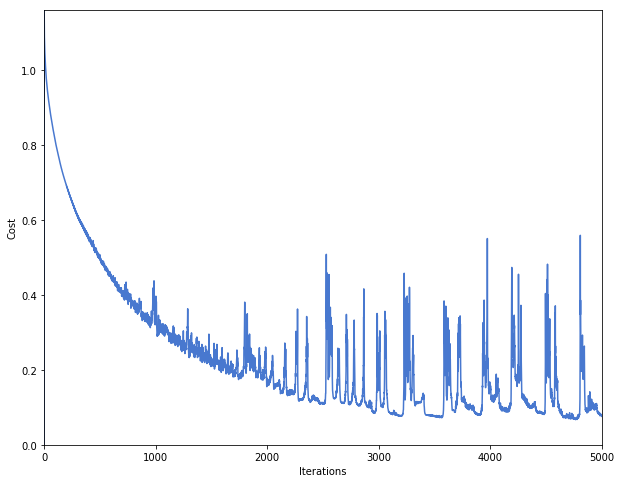

F-Score: 0.911


In [26]:
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average="micro")
print("F-Score:", round(f,3))

## notes
confusion matrix
test on real data
- record random real life events to gather more random sounds

In [27]:
l = [i for i in range(0,3)]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred,labels=[i for i in range(0,3)])
print(cm)

[[68  0  1]
 [ 3 83  4]
 [ 2 13 83]]


In [30]:
# from prettytable import PrettyTable
# count = [0.00 for i in range(0,3)]
# for i in y_true:
#     count[i] += 1
# print(count)


copy = list()
for index1, l in enumerate(cm):
    copy.append([])
    for index2, item in enumerate(l):
#         getcontext().prec = 4
#         print(Decimal(item / count[index1]))
        copy[index1].append(item / count[index1] * 100)
# to_print = PrettyTable([""]+names)
# for i in range(len(copy)):
#     to_print.add_row([names[i]] + copy[i])
# print(to_print)

# names = ["air_conditioner","car_horn","children_playing",
# "dog_bark","engine_idling",
# "siren","street_music"]


names = ["air_cond","child_play","strt_music"]
layout = "{!s:^10} {!s:^10} {!s:^10} {!s:^10}"
print(layout.format("","air_cond", "child_play","strt_music"))
list_layout = "{!s:<10} {:^10.4f} {:^10.4f} {:^10.4f}"
# nums = [12.0, 13.234234,12.2323232323,12.2323232323,12.2323232323,12.2323232323,99.123123123123,99.123123123123,99.123123123123,99.123123123123]
# print(list_layout.format("air_cond",*nums))
for i in range(len(copy)):
    to_print = [names[i]] + copy[i]
    print(list_layout.format(*to_print))

[69.0, 90.0, 98.0]
            air_cond  child_play strt_music
air_cond    98.5507     0.0000     1.4493  
child_play   3.3333    92.2222     4.4444  
strt_music   2.0408    13.2653    84.6939  


In [31]:
parent_dir = 'New-Data'
dirs = ["Fold2"]
features, labels = parse_audio_files(parent_dir, dirs)
# print(features)
# print(features.shape)
# print(labels)
# print(labels.shape)
# labels = one_hot_encode(labels)
print("finished")

0 Fold2


In [40]:
with tf.Session() as sess:
    saver.restore(sess, "./checkpoints/NN-model.ckpt")
    print("Model restored")
    new_pred = sess.run(tf.argmax(y_,1),feed_dict={X: features})
#     new_true = sess.run(tf.argmax(labels,1))
    saver.save(sess, "./checkpoints/"+"NN-model.ckpt")
print("finished")

INFO:tensorflow:Restoring parameters from ./checkpoints/NN-model.ckpt
Model restored
finished


In [39]:
# newtypes = {10: "driving",11:"keyboard",12:"mouseclick"}
newtypes = {3: "toilet"}
# for i,j in (labels,new_pred):
#     print(str(newtype[i]) + "->" + str(names[i]))
# for i in labels:
#     print(newtypes[i],end=" \t")
# print()
# for i in new_pred:
#     print(names[i], end="\t")
count = 0
sum = 0
for i in new_pred:
    print(names[i])
    sum += i
    if i == 2:
        count += 1
print(count*2 / sum)


strt_music
strt_music
strt_music
strt_music
strt_music
strt_music
strt_music
strt_music
strt_music
child_play
strt_music
strt_music
strt_music
strt_music
strt_music
strt_music
child_play
strt_music
strt_music
strt_music
strt_music
strt_music
0.952380952381


In [ ]:
## distinguish home events
### -watching tv
### -using toilet -> Starting point, get samples of this first and washing hands sounds, try to record in pocket as well as outside
### -housework (ie vacuum, chores)
### -talking
## Problems
### -phone in pocket
### -sampling size/length

## remove not needed sounds -> 
#     keep air conditioning, children playing, street music


In [41]:
parent_dir = 'New-Data'
dirs = ["fold3"]
features, labels = parse_audio_files(parent_dir, dirs)

0 fold3


In [42]:
with tf.Session() as sess:
    saver.restore(sess, "./checkpoints/NN-model.ckpt")
    print("Model restored")
    new_pred = sess.run(tf.argmax(y_,1),feed_dict={X: features})
#     new_true = sess.run(tf.argmax(labels,1))
    saver.save(sess, "./checkpoints/"+"NN-model.ckpt")
print("finished")

INFO:tensorflow:Restoring parameters from ./checkpoints/NN-model.ckpt
Model restored
finished


In [43]:

count = 0
sum = 0
for i in new_pred:
    print(names[i])
    sum += i
    if i == 2:
        count += 1
print(count*2 / sum)

child_play
strt_music
child_play
air_cond
0.5


In [44]:
## get recording of open/real space sounds, like cafe, office, etc
# analyze conituous ambient sound, if the sound changes, that would be the moment